In [72]:
from __future__ import division

from time import time
from sys import stdout
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Dropout, Activation, Flatten, Reshape
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.utils import np_utils
from keras import backend as K
from keras import objectives
from keras.datasets import mnist, cifar100

In [110]:
class Generator:
    
    def __init__(self, input_size):
        self.model = Sequential()
#         self.model.add(Dense(hidden_size, input_shape = (input_size,), activation = "elu"))
        self.model.add(Dense(64 * 7 * 7, input_shape=(input_size,), activation = "tanh"))
        self.model.add(Reshape((64, 7, 7)))
        self.model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", use_bias=True,
                      activation="tanh", data_format="channels_first"))
        self.model.add(UpSampling2D(size=(2, 2)))
        self.model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", use_bias=True,
                      activation="tanh", data_format="channels_first"))
        self.model.add(UpSampling2D(size=(2, 2)))
        self.model.add(Conv2D(filters=1, kernel_size=(5, 5), padding="same", use_bias=True,
                      activation="tanh", data_format="channels_first"))
        
    def get_model(self):
        return self.model
        
    def compile_model(self, **kwargs):
        self.model.compile(**kwargs)
        
    def predict(self, X):
        return self.model.predict(X)
        
    def train_on_batch(self, **kwargs):
        return self.model.train_on_batch(**kwargs)
    
    def save_weights(self, file):
        self.model.save_weights(file)
        
    def load_weights(self, file):
        self.model.load_weights(file)

In [117]:
class Discriminator:
    
    def __init__(self, output_size):
        self.model = Sequential()
        self.model.add(Conv2D(filters=32, kernel_size=5, padding="same", use_bias=True,
                                     input_shape=(1, img_rows, img_cols), activation="tanh", data_format="channels_first"))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(filters=32, kernel_size=5, padding="same", use_bias=True,
                              activation="tanh", data_format="channels_first"))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(64 * 7 * 7, activation="tanh"))
        self.model.add(Dense(output_size, activation = "sigmoid"))
        
    def get_model(self):
        return self.model
    
    def compile_model(self, **kwargs):
        self.model.compile(**kwargs)
        
    def predict(self, X):
        return self.model.predict(X)
        
    def train_on_batch(self, X, Y):
        return self.model.train_on_batch(X, Y)
    
    def trainable(self, trainable):
        self.model.trainable = trainable
    
    def save_weights(self, file):
        self.model.save_weights(file)
        
    def load_weights(self, file):
        self.model.load_weights(file)

In [118]:
class GeneratorAndDiscriminator:
    
    def __init__(self, generator, discriminator):
        self.model = Sequential()
        self.model.add(generator)
        self.model.add(discriminator)
        
    def get_model(self):
        return self.model
        
    def compile_model(self, **kwargs):
        self.model.compile(**kwargs)
        
    def predict(self, X):
        return self.model.predict(X)
        
    def train_on_batch(self, X, Y):
        return self.model.train_on_batch(X, Y)

In [119]:
def print_progress(epoch, epochs, minibatch, minibatches, start_time, g_loss, d_loss):
    
    bar_length = 50
    
    progress_bar = "[" + "=" * int(bar_length * epoch / epochs) + \
    ">" + "-" * int(bar_length * (epochs - epoch) / epochs) + "]"
    
    time_taken = (time() - start_time)
    
    minibatches_complete = epoch * minibatches + minibatch + 1
    total_minibatches = epochs * minibatches
    
    secs = np.ceil(time_taken * total_minibatches / minibatches_complete - time_taken)
    hours = np.floor(secs / 3600)
    secs -= hours * 3600
    mins = np.floor(secs / 60)
    secs -= mins * 60
    
    stdout.write("\r" + "Epoch: {}/{} Minibatch: {}/{} ".format(epoch, epochs, minibatch, minibatches) + 
#                   progress_bar + 
                  "{}% ETA: {}h {}m {}s ".format(int(epoch * 100 / epochs), int(hours), int(mins), int(secs)) + 
                 "g_loss: {} ".format(g_loss[0]) + "d_loss: {} ".format(d_loss[0]))
    stdout.flush()

In [120]:
# Model params
g_input_size = 100    # Random noise dimension coming into generator, per output vector
d_output_size = 1    # Single dimension for 'real' vs. 'fake'

# Data params
nb_classes = 10
img_rows, img_cols = 28, 28

In [121]:
##load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

##reshape data
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#centre data on zero
x_train = (x_train - 255 / 2) / (255 / 2)
x_test = (x_test - 255 / 2) / (255 / 2)

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

num_epochs = 100
d_steps = 1 # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

#parameter settings
minibatch_size = 128

num_patterns = len(x_train)
num_minibatches = int(num_patterns / minibatch_size)

In [122]:
#construct generator
G = Generator(g_input_size)

#construct discriminator
D = Discriminator(d_output_size)

##generator and discriminator
GD = GeneratorAndDiscriminator(G.get_model(), D.get_model())

##weight directory
weight_dir = "mnist_weights"
if not os.path.isdir(weight_dir):
    os.mkdir(weight_dir)
    
##progress file
loss_file = os.path.join(weight_dir, "progress.txt")

##load weights
G_weight_file = os.path.join(weight_dir, "weights_G.h5")
D_weight_file = os.path.join(weight_dir, "weights_D.h5")

if os.path.isfile(loss_file):
    
    loss = np.loadtxt(loss_file)
    G.load_weights(G_weight_file)
    D.load_weights(D_weight_file)
    
else:
    
    losses = np.zeros((num_epochs, 2))
    
#compile G
G.compile_model(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#compile D
D.compile_model(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#compile GD
GD.compile_model(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time()

for epoch in range(num_epochs):
    
    if losses[epoch].any():
        continue
        
    for minibatch in range(num_minibatches):
        
#         '''
#         train D
#         '''

        #get real data
        d_real_data = x_train[minibatch * minibatch_size : (minibatch + 1) * minibatch_size]
#         print d_real_data.shape
        d_real_targets = np.ones(minibatch_size)

        #generate fake data
        d_gen_input = np.random.uniform(-1, 1, size=(minibatch_size, g_input_size))
        d_fake_data = G.predict(d_gen_input)
#         print d_fake_data.shape
        d_fake_targets = np.zeros(minibatch_size)

        #combine real and fake data
        d_data = np.append(d_real_data, d_fake_data, axis=0)
        d_targets = np.append(d_real_targets, d_fake_targets)

        #fit discriminator
        D.trainable(True)
#         d_loss = D.train_on_batch(d_data, d_targets, shuffle=True, epochs=epochs,
#               batch_size=1, validation_split=0.0, verbose=0)
        d_loss = D.train_on_batch(d_data, d_targets)
        
#         '''
#         train G
#         '''
        
        #generate data from noise
        g_gen_input = np.random.uniform(-1, 1, size=(minibatch_size, g_input_size))
        
        #target
        g_targets = np.ones(minibatch_size)
        
        #fit generator
        D.trainable(False)
#         g_loss = GD.train_on_batch(gen_input, target, shuffle=True, epochs=epochs,
#               batch_size=1, validation_split=0.0, verbose=0)
        g_loss = GD.train_on_batch(g_gen_input, g_targets)
        
        print_progress(epoch, num_epochs, minibatch, num_minibatches, start_time, g_loss, d_loss)
        
    #save losses
    losses[epoch] = [g_loss[0], d_loss[0]]
    np.savetxt(loss_file, losses)

    #save weights
    G.save_weights(G_weight_file)
    D.save_weights(D_weight_file)

print "\nDONE"

Epoch: 99/100 Minibatch: 467/468 99% ETA: 0h 0m 0s g_loss: 0.200304612517 d_loss: 1.02418911457    
DONE


In [123]:
def combine_images(images):
    
    num_images, _, img_rows, img_cols = images.shape 
    
    num_images_cols = np.ceil(np.sqrt(num_images)).astype(np.int)
    num_images_rows = np.ceil(num_images / num_images_cols).astype(np.int)
    
    combined_images = np.zeros((num_images_rows * img_rows, num_images_cols * img_cols))
    
    for i in range(num_images):
        
        c = i % num_images_cols
        r = np.floor(i / num_images_cols).astype(np.int)
        
        combined_images[r * img_rows : (r + 1) * img_rows, c * img_cols : (c + 1) * img_cols] = images[i, 0]
    
    return combined_images

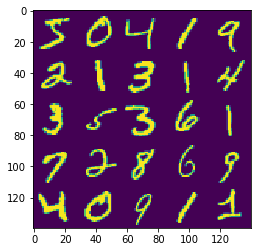

In [124]:
num_samples = 25
plt.imshow(combine_images(x_train[:num_samples]))
plt.show()

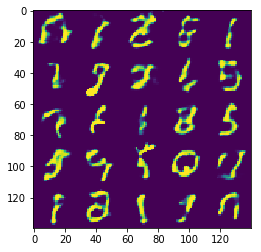

[[ 0.89327854]
 [ 0.82845938]
 [ 0.85256052]
 [ 0.79169232]
 [ 0.84220088]
 [ 0.76128554]
 [ 0.79734284]
 [ 0.92074817]
 [ 0.76633811]
 [ 0.87617153]
 [ 0.81774372]
 [ 0.80600399]
 [ 0.84601623]
 [ 0.87227249]
 [ 0.81074107]
 [ 0.81904501]
 [ 0.84930205]
 [ 0.69780433]
 [ 0.89790422]
 [ 0.86030734]
 [ 0.84953874]
 [ 0.89827526]
 [ 0.75272006]
 [ 0.83391917]
 [ 0.90472358]]


In [125]:
gen_input = np.random.uniform(-1, 1, size=(num_samples, g_input_size))
forgery = G.model.predict(gen_input)

# print np.mean(forgery)

plt.imshow(combine_images(forgery))
plt.show()

print D.model.predict(forgery)